# Description

The main idea is to test the same CNNs that are known to have a good perfomance in medical image segmentation, particularly those that were tested on a retina dataset such as the [DRIVE dataset](https://drive.grand-challenge.org/). Therefore, we tested three models on the task of blood vessel segmentation:

- U-net: This model was based in the paper [U-Net: Convolutional Networks for Biomedical](https://arxiv.org/pdf/1505.04597.pdf).

- M2V-net: This model was prepared using a pretrained layers of [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) as the enconder, and for the decoder it was used a upsample block implemented in pix2pix. The complete description of this model can be found as an example in [Tensorflow site](https://www.tensorflow.org/tutorials/images/segmentation).

- M2U-net: This model was based in this [paper](https://arxiv.org/pdf/1811.07738.pdf), some of the layers are based in the MobileNetV2.

## https://github.com/RGivisiez/Blood-Vessel-Segmentation

In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
import os
import re
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, \
                            roc_curve, roc_auc_score

Vérifier les tailles des images

# U-net model

## Dataset Parameters

In [99]:
# Images parameters
channels = 3
height = 300
width = 300

# Resize parameters
resize_wh = 512
crop_wh = 128

test_batch = 2

In [100]:
# File paths
imgs_train = "../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/Original/train/"
label_imgs_train = "../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/groundT/train/"
#masks_train = "./DRIVE/training/mask/"

imgs_test = "../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/Original/test/"
label_imgs_test = "../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/groundT/test/"
#masks_test = "./DRIVE/test/mask/"

In [101]:
"""# File paths
imgs_train = "_dataset_deep_Angiogram_png/Original/train/"
label_imgs_train = "_dataset_deep_Angiogram_png/groundT/train/"
#masks_train = "./DRIVE/training/mask/"

imgs_test = "_dataset_deep_Angiogram_png/Original/test/"
label_imgs_test = "_dataset_deep_Angiogram_png/groundT/test/"
"""

'# File paths\nimgs_train = "_dataset_deep_Angiogram_png/Original/train/"\nlabel_imgs_train = "_dataset_deep_Angiogram_png/groundT/train/"\n#masks_train = "./DRIVE/training/mask/"\n\nimgs_test = "_dataset_deep_Angiogram_png/Original/test/"\nlabel_imgs_test = "_dataset_deep_Angiogram_png/groundT/test/"\n'

In [102]:
image_paths = os.listdir(imgs_train)
label_paths = os.listdir(label_imgs_train)

image_paths = [imgs_train + i for i in image_paths]
label_paths = [label_imgs_train + i for i in label_paths]

In [103]:
import re
image_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
label_paths.sort(key=lambda f: int(re.sub('\D', '', f)))

In [104]:
print(image_paths[100])
print(label_paths[100])

../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/Original/train/127.png
../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/groundT/train/127_gt.png


In [105]:
len(image_paths), len(label_paths)

(108, 108)

## Construct the train dataset

In [106]:
shuffle_buffer = len(image_paths) * (resize_wh // crop_wh)**2
batch_size = 32

print('Shuffle buffer size: {}'.format(shuffle_buffer))

Shuffle buffer size: 1728


In [107]:
def load(image_paths, label_paths):
    
    image_string = tf.io.read_file(image_paths)
    label_string = tf.io.read_file(label_paths)
    
    #Don't use tf.image.decode_image, or the output shape will be undefined
    ##image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.io.decode_png(image_string)
    #print('ok')

    label = tf.io.decode_png(label_string) #tf.image.decode_gif(label_string)
    label = tf.image.rgb_to_grayscale(label)#tf.squeeze(tf.image.rgb_to_grayscale(label), axis=0)
    label_shape = label.shape    

    image = tf.cast(image, dtype=tf.float32)
    label = tf.cast(label, dtype=tf.float32)
    
    image.set_shape((height, width, channels))
    label.set_shape((height, width, 1))

    print('Load')
    print(image.shape) #Check image shape
    print(label.shape) #Check label shape

    return image, label

In [108]:
def augment(image, label):

    image = rgb2gray(image)
    image_shape = image.shape
    label_shape = label.shape

    print('Augment - Start')
    print(image.shape) #Check image shape
    print(label.shape) #Check label shape

    image, label = normalize(image, label)

    image = tf.py_function(clahe_equalized, [image], tf.uint8)
    image.set_shape(image_shape)

    image = tf.image.adjust_gamma(image, gamma=1.2)

    image = tf.image.resize(image, [resize_wh, resize_wh], method='nearest')
    label = tf.image.resize(label, [resize_wh, resize_wh], method='nearest')

    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    #image, label = random_flip(image, label)

    print('Augment - middle')
    print(image.shape) #Check image shape
    print(label.shape) #Check label shape

    image, label = crop(image, label, crop_wh, image.shape[-1])

    print('Augment - end')
    print(image.shape) #Check image shape
    print(label.shape) #Check label shape

    return image, label

In [109]:
class random_flip_rot(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.rot_inputs = tf.keras.layers.RandomRotation(0.15, seed=seed)
    self.rot_labels = tf.keras.layers.RandomRotation(0.15, seed=seed)

  def call(self, inputs, labels):
    
    ran = tf.random.uniform([2], maxval=1)

    if ran[0] < 0.5:
      inputs = self.flip_inputs(inputs)
      labels = self.flip_labels(labels)

    if ran[1] < 0.5:
      inputs = self.rot_inputs(inputs)
      labels = self.rot_labels(labels)

    return inputs, labels

In [110]:
def clahe_equalized(image):

    image = image.numpy()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image.astype(np.uint8))

    return np.expand_dims(image, axis=-1)

In [111]:
def normalize(image, labels):
  
  mean = 83.15841582964605
  std = 57.07514784246855 

  image = (image - mean) / std

  max = tf.math.reduce_max(image)
  min = tf.math.reduce_min(image)

  image = 255 * (image - min) / (max - min)

  return image, labels

def random_flip(image, labels):
  
  '''does a random flip of the image and mask'''

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    labels = tf.image.flip_left_right(labels)

  return image, labels

def rgb2gray(image):
    gray_scale = image[:,:,0]*0.299 + image[:,:,1]*0.587 \
                + image[:,:,2]*0.114
    return tf.expand_dims(gray_scale, axis=-1)

In [112]:
def crop(image, label, cut_size, image_channels):

  """Returns a cropped square image."""
  
  shape = image.shape

  image_new = tf.zeros((0, cut_size, cut_size, image_channels))
  label_new = tf.zeros((0, cut_size, cut_size, 1))


  for idx in range(0, shape[1] // cut_size):
    for idy in range(0, shape[0] // cut_size):

      image_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          image, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
      label_aux = tf.expand_dims(tf.image.crop_to_bounding_box(
          label, idy * cut_size, idx * cut_size, cut_size, cut_size), axis=0)
    
      image_new = tf.concat([image_new, image_aux], axis=0)
      label_new = tf.concat([label_new, label_aux], axis=0)

  return image_new, label_new

In [113]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [114]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

dataset = dataset.map(load)
dataset = dataset.map(augment)
dataset = dataset.map(random_flip_rot())

dataset = dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))
#print('ok')
train_dataset, val_dataset = split_dataset(dataset, 0.1)

train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

del(dataset)

Load
(300, 300, 3)
(300, 300, 1)
Augment - Start
(300, 300, 1)
(300, 300, 1)
Augment - middle
(512, 512, 1)
(512, 512, 1)
Augment - end
(16, 128, 128, 1)
(16, 128, 128, 1)


In [115]:
train_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>)

## Define U-net model

In [116]:
from tensorflow.keras.layers import Input, concatenate, BatchNormalization, \
                                    Conv2D, MaxPooling2D, MaxPool2D, \
                                    UpSampling2D, Reshape, Dropout, Reshape, \
                                    Permute, Activation, Conv2DTranspose,  \
                                    Concatenate

In [117]:
save_path = 'my_Unet_Mars_300epochs.h5'
save_best_only = True

### Auxiliary functions for the model

In [118]:
def conv2d_block(input, n_filters, kernel_size = 3, activation='relu'):

  x = input

  for i in range(2):
    x = Conv2D(filters=n_filters,
                               kernel_size=(kernel_size, kernel_size),
                               activation=None,
                               padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

  return x

def one_encoder_block(input, n_filters):

  f = conv2d_block(input, n_filters)
  x = MaxPool2D(pool_size=(2, 2), padding='same')(f)

  return f, x

def one_decoder_block(inputs, decoder_output, n_filters, kernel_size = 3):

  f = Conv2DTranspose(filters=n_filters,
                                      kernel_size=(kernel_size, kernel_size),
                                      padding = 'same',
                                      strides= (2, 2))(inputs)

  f = Concatenate()([f, decoder_output])
  f = conv2d_block(f, n_filters, kernel_size=3)

  return f

## Build U-net

- Build U-net with input (crop_hw, crop_hw, 1)

In [119]:
def encoder(inputs):

  f1, x = one_encoder_block(inputs, 32) 
  f2, x = one_encoder_block(x, 64) 
  f3, x = one_encoder_block(x, 128) 

  return x, (f1, f2, f3)

def bottle_neck(input, n_filters=256):  #goulot (khan9a)
  
  f = conv2d_block(input, n_filters)

  return f

def decoder(inputs, encoder_outputs, n_labels):

  f1, f2, f3 = encoder_outputs

  x = one_decoder_block(inputs, f3, n_filters=128, kernel_size = 3)
  x = one_decoder_block(x, f2, n_filters=64, kernel_size = 3)
  x = one_decoder_block(x, f1, n_filters=32, kernel_size = 3)

  outputs = Conv2D(n_labels, (1, 1), activation='sigmoid')(x)

  return outputs

In [120]:
def build_unet(patch_height, patch_width, n_ch):

  input = Input(shape=(patch_height, patch_width, n_ch))

  x, encoder_outputs = encoder(input)
  
  bottleneck = bottle_neck(x)

  output = decoder(bottleneck, encoder_outputs, 1)

  model = Model(inputs=input, outputs=output)

  return model

In [121]:
model1 = build_unet(crop_wh, crop_wh, 1)

## Callbacks

### Dice and Jaccard functions

In [122]:
def jaccard(y_true, y_pred):

  intersection = tf.reduce_sum(y_true * y_pred)
  sum_ = tf.reduce_sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)
    
  return jac

In [123]:
def dice(y_true, y_pred):
    
  y_true = tf.cast(y_true, tf.float32)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / denominator

### Callbacks

In [124]:
checkpointer = ModelCheckpoint(save_path,
                               verbose=1, monitor='val_loss', mode='auto',
                               save_best_only=save_best_only)

class CustomCallback(tf.keras.callbacks.Callback):

  def __init__(self, model, dataset, display_freq=9):

    self.model = model
    self.dataset = dataset
    self.display_freq = display_freq

  def on_epoch_end(self, epoch, logs=None):

    if epoch % self.display_freq == 0:
      
      plt.figure(figsize=(10, 10))
        
      for data in self.dataset.take(1):

          image = data[0].numpy()
          label = data[1].numpy()

          pred = self.model.predict(image)

          print(' ')
          
          jac = jaccard(data[1], tf.convert_to_tensor(pred)).numpy()
          dic = dice(data[1], tf.convert_to_tensor(pred)).numpy()

          print('jaccard: {:2.2f}'.format(jac))
          print('dice: {:2.2f}'.format(dic))

          print(' ')

          #pred[pred < 0.5] = 0
          #pred[pred >= 0.5] = 1

          ax = plt.subplot(2, 2, 1)
            
          plot = cv2.cvtColor(label[0, ...].astype('float32'), \
                              cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('True')
          plt.axis('off')
          
          ax = plt.subplot(2, 2, 2)
            
          plot = cv2.cvtColor(pred[0, ...].astype('float32'), \
                              cv2.IMREAD_COLOR)

          plt.imshow(plot)
          plt.title('Predicted')
          plt.axis('off')

      plt.show()
    
      auc = []

      for data in self.dataset:
            
          pred = self.model.predict(data[0])
          label = data[1].numpy()
        
          label[label > 0.5] = 1
          label[label <= 0.5] = 0

          auc.append(roc_auc_score(label.reshape(-1), pred.reshape(-1)))

      auc = np.asarray(auc)

      print(' ')
      print('auc: {:2.2f}'.format(np.mean(auc), np.std(auc)))
      print(' ')

## Compile and show the model architecture

In [125]:
model1.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', jaccard, dice])

In [126]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                           

## Train

In [127]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [128]:
import datetime
time_start1 = datetime.datetime.now()
print("     Training Start at", time_start1)

     Training Start at 2023-03-11 20:49:02.075862


Epoch 1/300
     48/Unknown - 23s 152ms/step - loss: 0.2547 - accuracy: 0.9339 - jaccard: 0.1019 - dice: 0.1832
Epoch 1: val_loss improved from inf to 0.49260, saving model to my_Unet_Mars_300epochs.h5
1/1 [==============================] - 0s 337ms/step
 
jaccard: 0.05
dice: 0.10
 


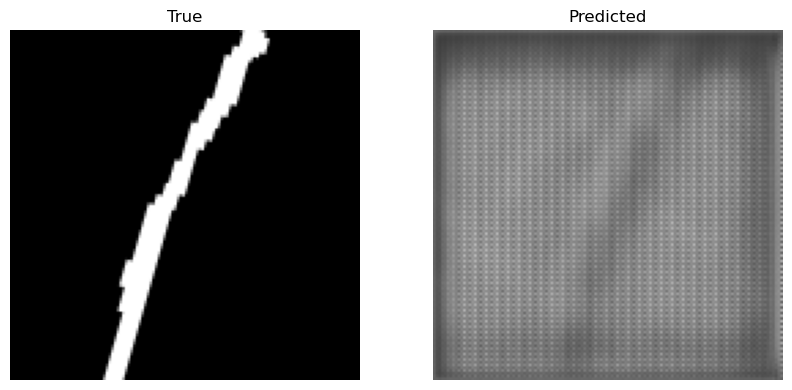

1/1 [==============================] - 0s 348ms/step
 
auc: 0.64
 
48/48 [==============================] - 64s 1s/step - loss: 0.2547 - accuracy: 0.9339 - jaccard: 0.1019 - dice: 0.1832 - val_loss: 0.4926 - val_accuracy: 0.8293 - val_jaccard: 0.0588 - val_dice: 0.1108
Epoch 2/300
48/48 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9577 - jaccard: 0.2010 - dice: 0.3335
Epoch 2: val_loss improved from 0.49260 to 0.26635, saving model to my_Unet_Mars_300epochs.h5
48/48 [==============================] - 20s 292ms/step - loss: 0.1427 - accuracy: 0.9577 - jaccard: 0.2010 - dice: 0.3335 - val_loss: 0.2663 - val_accuracy: 0.9367 - val_jaccard: 0.0471 - val_dice: 0.0898
Epoch 3/300
48/48 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9602 - jaccard: 0.2541 - dice: 0.4041
Epoch 3: val_loss improved from 0.26635 to 0.24312, saving model to my_Unet_Mars_300epochs.h5
48/48 [==============================] - 24s 401ms/step - loss: 0.1157 - accurac

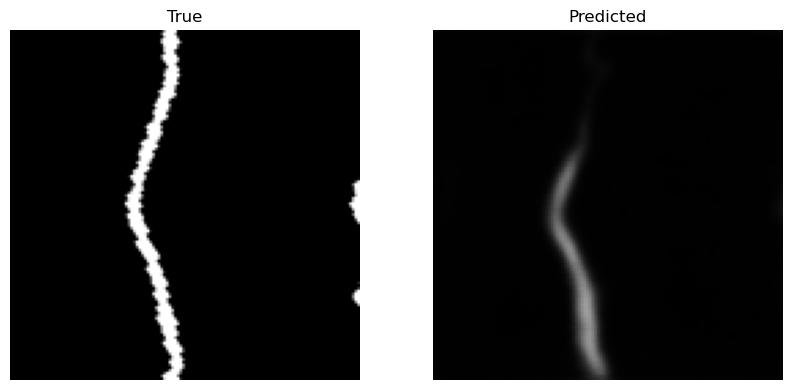

1/1 [==============================] - 0s 24ms/step
 
auc: 0.92
 
48/48 [==============================] - 45s 840ms/step - loss: 0.0780 - accuracy: 0.9661 - jaccard: 0.3975 - dice: 0.5682 - val_loss: 0.1494 - val_accuracy: 0.9486 - val_jaccard: 0.2308 - val_dice: 0.3717
Epoch 11/300
48/48 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9675 - jaccard: 0.4165 - dice: 0.5870
Epoch 11: val_loss improved from 0.14940 to 0.09433, saving model to my_Unet_Mars_300epochs.h5
48/48 [==============================] - 19s 290ms/step - loss: 0.0739 - accuracy: 0.9675 - jaccard: 0.4165 - dice: 0.5870 - val_loss: 0.0943 - val_accuracy: 0.9602 - val_jaccard: 0.3681 - val_dice: 0.5357
Epoch 12/300
48/48 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9676 - jaccard: 0.4161 - dice: 0.5868
Epoch 12: val_loss did not improve from 0.09433
48/48 [==============================] - 18s 280ms/step - loss: 0.0732 - accuracy: 0.9676 - jaccard: 0.4161 - dice: 0.586

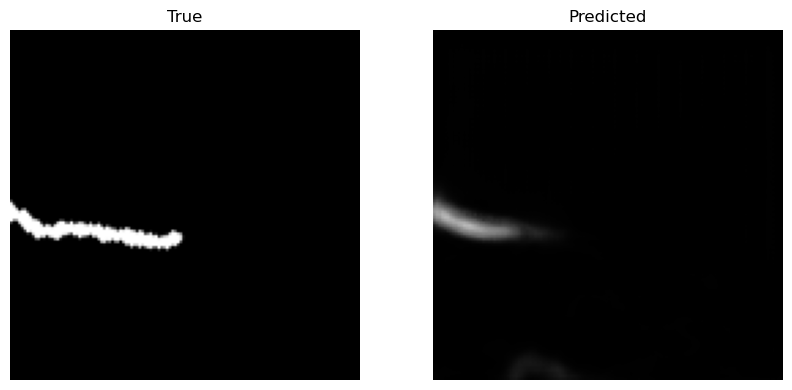

1/1 [==============================] - 0s 26ms/step
 
auc: 0.97
 
48/48 [==============================] - 44s 829ms/step - loss: 0.0671 - accuracy: 0.9689 - jaccard: 0.4503 - dice: 0.6203 - val_loss: 0.0895 - val_accuracy: 0.9649 - val_jaccard: 0.3929 - val_dice: 0.5623
Epoch 20/300
48/48 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9692 - jaccard: 0.4507 - dice: 0.6205
Epoch 20: val_loss improved from 0.08054 to 0.07747, saving model to my_Unet_Mars_300epochs.h5
48/48 [==============================] - 18s 279ms/step - loss: 0.0673 - accuracy: 0.9692 - jaccard: 0.4507 - dice: 0.6205 - val_loss: 0.0775 - val_accuracy: 0.9666 - val_jaccard: 0.4570 - val_dice: 0.6250
Epoch 21/300
48/48 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9691 - jaccard: 0.4568 - dice: 0.6262
Epoch 21: val_loss did not improve from 0.07747
48/48 [==============================] - 19s 293ms/step - loss: 0.0667 - accuracy: 0.9691 - jaccard: 0.4568 - dice: 0.626

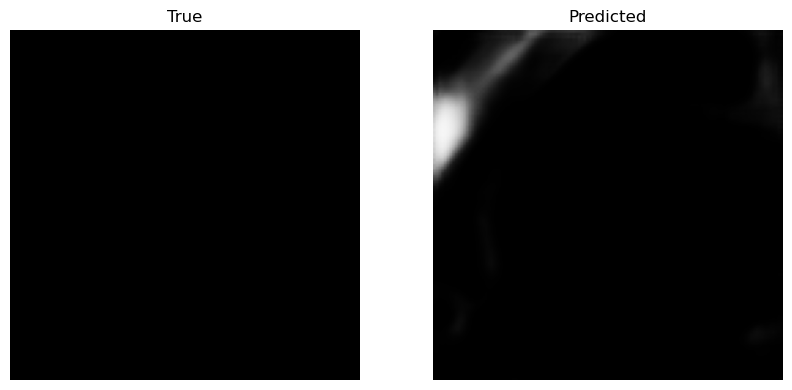

1/1 [==============================] - 0s 24ms/step
 
auc: 0.99
 
48/48 [==============================] - 45s 834ms/step - loss: 0.0629 - accuracy: 0.9697 - jaccard: 0.4730 - dice: 0.6415 - val_loss: 0.0756 - val_accuracy: 0.9661 - val_jaccard: 0.4527 - val_dice: 0.6212
Epoch 29/300
48/48 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9705 - jaccard: 0.4778 - dice: 0.6459
Epoch 29: val_loss did not improve from 0.07375
48/48 [==============================] - 19s 288ms/step - loss: 0.0619 - accuracy: 0.9705 - jaccard: 0.4778 - dice: 0.6459 - val_loss: 0.0764 - val_accuracy: 0.9685 - val_jaccard: 0.4615 - val_dice: 0.6292
Epoch 30/300
48/48 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9708 - jaccard: 0.4765 - dice: 0.6446
Epoch 30: val_loss improved from 0.07375 to 0.07286, saving model to my_Unet_Mars_300epochs.h5
48/48 [==============================] - 19s 291ms/step - loss: 0.0629 - accuracy: 0.9708 - jaccard: 0.4765 - dice: 0.644

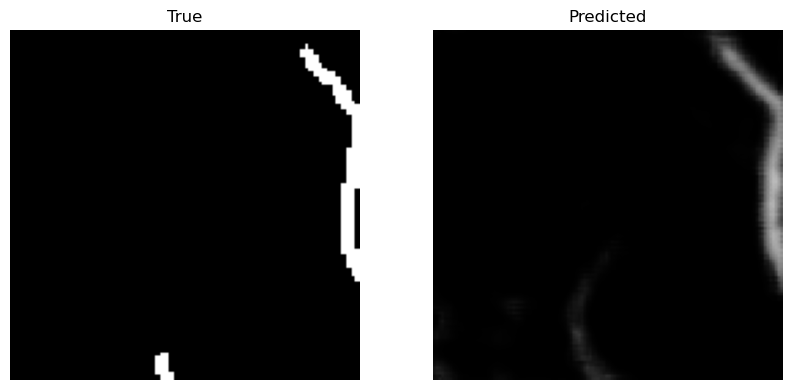

1/1 [==============================] - 0s 25ms/step
 
auc: 0.98
 
48/48 [==============================] - 45s 845ms/step - loss: 0.0614 - accuracy: 0.9705 - jaccard: 0.4817 - dice: 0.6491 - val_loss: 0.0823 - val_accuracy: 0.9636 - val_jaccard: 0.3933 - val_dice: 0.5618
Epoch 38/300
48/48 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9705 - jaccard: 0.4807 - dice: 0.6486
Epoch 38: val_loss did not improve from 0.06769
48/48 [==============================] - 19s 292ms/step - loss: 0.0614 - accuracy: 0.9705 - jaccard: 0.4807 - dice: 0.6486 - val_loss: 0.0782 - val_accuracy: 0.9653 - val_jaccard: 0.4610 - val_dice: 0.6267
Epoch 39/300
48/48 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9704 - jaccard: 0.4851 - dice: 0.6527
Epoch 39: val_loss did not improve from 0.06769
48/48 [==============================] - 19s 287ms/step - loss: 0.0615 - accuracy: 0.9704 - jaccard: 0.4851 - dice: 0.6527 - val_loss: 0.0691 - val_accuracy: 0.9674 - v

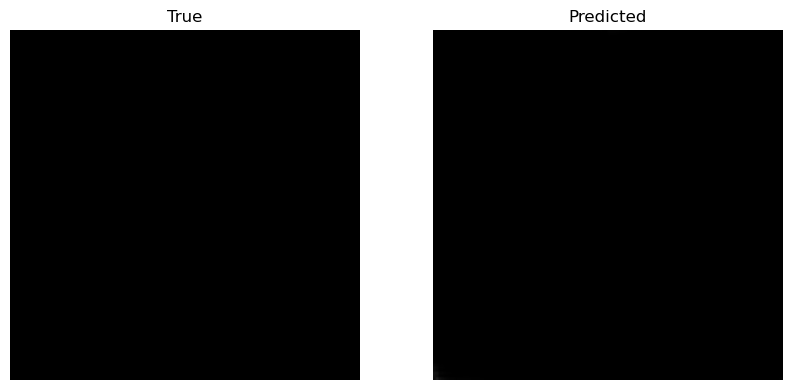

1/1 [==============================] - 0s 27ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 830ms/step - loss: 0.0577 - accuracy: 0.9722 - jaccard: 0.5043 - dice: 0.6700 - val_loss: 0.0702 - val_accuracy: 0.9671 - val_jaccard: 0.4680 - val_dice: 0.6343
Epoch 47/300
48/48 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9699 - jaccard: 0.4879 - dice: 0.6552
Epoch 47: val_loss did not improve from 0.06769
48/48 [==============================] - 19s 286ms/step - loss: 0.0608 - accuracy: 0.9699 - jaccard: 0.4879 - dice: 0.6552 - val_loss: 0.0744 - val_accuracy: 0.9630 - val_jaccard: 0.4675 - val_dice: 0.6348
Epoch 48/300
48/48 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9715 - jaccard: 0.4935 - dice: 0.6601
Epoch 48: val_loss did not improve from 0.06769
48/48 [==============================] - 18s 276ms/step - loss: 0.0592 - accuracy: 0.9715 - jaccard: 0.4935 - dice: 0.6601 - val_loss: 0.0720 - val_accuracy: 0.9656 - v

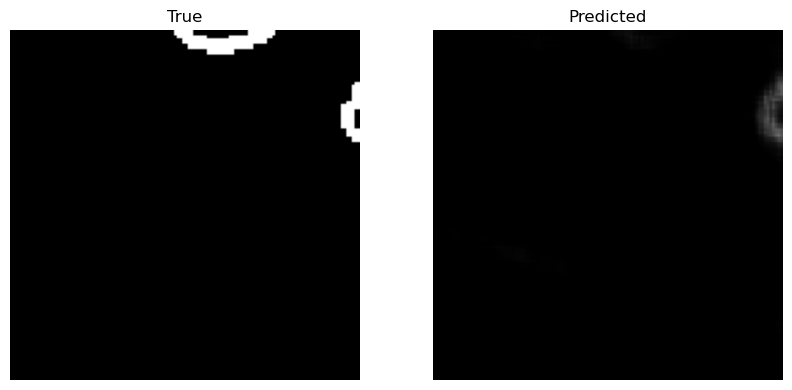

1/1 [==============================] - 0s 27ms/step
 
auc: 0.99
 
48/48 [==============================] - 49s 927ms/step - loss: 0.0588 - accuracy: 0.9710 - jaccard: 0.5003 - dice: 0.6664 - val_loss: 0.0755 - val_accuracy: 0.9669 - val_jaccard: 0.4736 - val_dice: 0.6409
Epoch 56/300
48/48 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9722 - jaccard: 0.5093 - dice: 0.6740
Epoch 56: val_loss did not improve from 0.06598
48/48 [==============================] - 19s 280ms/step - loss: 0.0567 - accuracy: 0.9722 - jaccard: 0.5093 - dice: 0.6740 - val_loss: 0.0702 - val_accuracy: 0.9670 - val_jaccard: 0.5116 - val_dice: 0.6753
Epoch 57/300
48/48 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9722 - jaccard: 0.5106 - dice: 0.6753
Epoch 57: val_loss did not improve from 0.06598
48/48 [==============================] - 19s 283ms/step - loss: 0.0571 - accuracy: 0.9722 - jaccard: 0.5106 - dice: 0.6753 - val_loss: 0.0694 - val_accuracy: 0.9659 - v

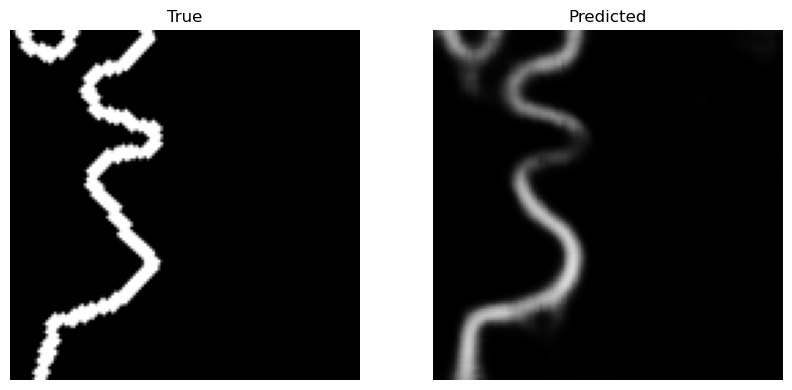

1/1 [==============================] - 0s 26ms/step
 
auc: 0.99
 
48/48 [==============================] - 45s 831ms/step - loss: 0.0539 - accuracy: 0.9737 - jaccard: 0.5258 - dice: 0.6885 - val_loss: 0.0690 - val_accuracy: 0.9661 - val_jaccard: 0.4784 - val_dice: 0.6448
Epoch 65/300
48/48 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9742 - jaccard: 0.5244 - dice: 0.6874
Epoch 65: val_loss did not improve from 0.06598
48/48 [==============================] - 19s 287ms/step - loss: 0.0541 - accuracy: 0.9742 - jaccard: 0.5244 - dice: 0.6874 - val_loss: 0.0676 - val_accuracy: 0.9675 - val_jaccard: 0.5008 - val_dice: 0.6642
Epoch 66/300
48/48 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9713 - jaccard: 0.5136 - dice: 0.6778
Epoch 66: val_loss did not improve from 0.06598
48/48 [==============================] - 19s 288ms/step - loss: 0.0564 - accuracy: 0.9713 - jaccard: 0.5136 - dice: 0.6778 - val_loss: 0.0800 - val_accuracy: 0.9669 - v

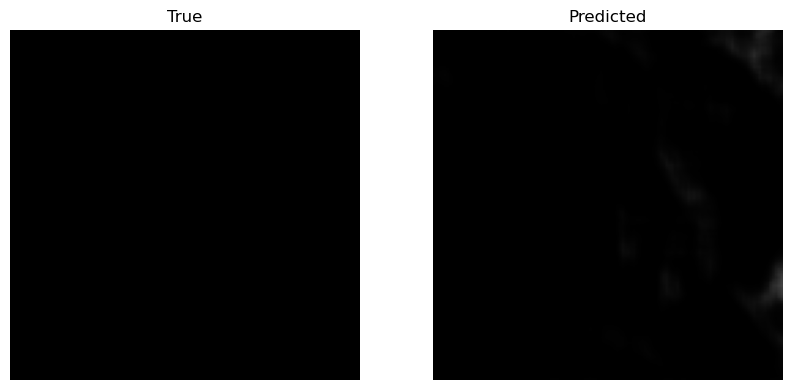

1/1 [==============================] - 0s 26ms/step
 
auc: 0.99
 
48/48 [==============================] - 45s 850ms/step - loss: 0.0530 - accuracy: 0.9740 - jaccard: 0.5330 - dice: 0.6949 - val_loss: 0.0678 - val_accuracy: 0.9676 - val_jaccard: 0.4921 - val_dice: 0.6584
Epoch 74/300
48/48 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9729 - jaccard: 0.5272 - dice: 0.6898
Epoch 74: val_loss did not improve from 0.06598
48/48 [==============================] - 19s 291ms/step - loss: 0.0538 - accuracy: 0.9729 - jaccard: 0.5272 - dice: 0.6898 - val_loss: 0.0688 - val_accuracy: 0.9679 - val_jaccard: 0.4908 - val_dice: 0.6570
Epoch 75/300
48/48 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9731 - jaccard: 0.5308 - dice: 0.6929
Epoch 75: val_loss improved from 0.06598 to 0.06568, saving model to my_Unet_Mars_300epochs.h5
48/48 [==============================] - 19s 287ms/step - loss: 0.0534 - accuracy: 0.9731 - jaccard: 0.5308 - dice: 0.692

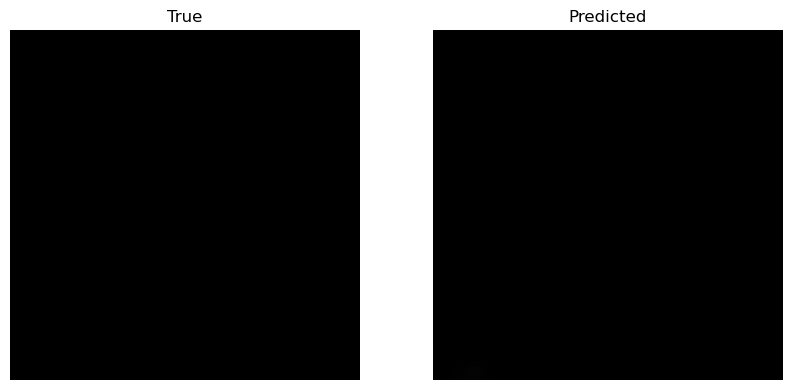

1/1 [==============================] - 0s 26ms/step
 
auc: 0.99
 
48/48 [==============================] - 45s 839ms/step - loss: 0.0530 - accuracy: 0.9732 - jaccard: 0.5288 - dice: 0.6909 - val_loss: 0.0677 - val_accuracy: 0.9692 - val_jaccard: 0.5061 - val_dice: 0.6704
Epoch 83/300
48/48 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9725 - jaccard: 0.5319 - dice: 0.6937
Epoch 83: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0529 - accuracy: 0.9725 - jaccard: 0.5319 - dice: 0.6937 - val_loss: 0.0692 - val_accuracy: 0.9674 - val_jaccard: 0.5012 - val_dice: 0.6664
Epoch 84/300
48/48 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9733 - jaccard: 0.5303 - dice: 0.6920
Epoch 84: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 282ms/step - loss: 0.0525 - accuracy: 0.9733 - jaccard: 0.5303 - dice: 0.6920 - val_loss: 0.0676 - val_accuracy: 0.9675 - v

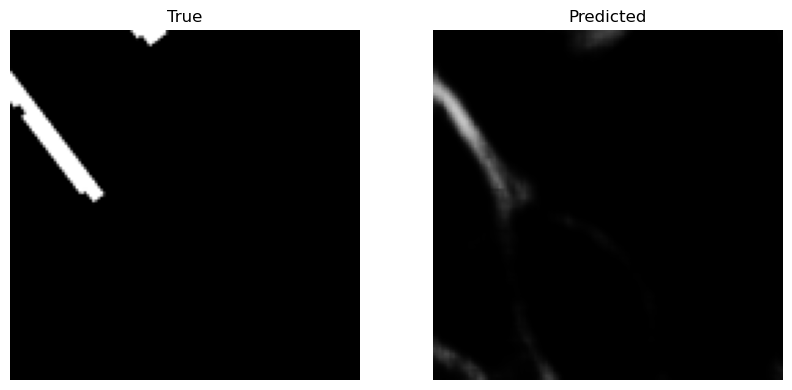

1/1 [==============================] - 0s 40ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 825ms/step - loss: 0.0531 - accuracy: 0.9727 - jaccard: 0.5312 - dice: 0.6928 - val_loss: 0.0742 - val_accuracy: 0.9673 - val_jaccard: 0.4884 - val_dice: 0.6537
Epoch 92/300
48/48 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9749 - jaccard: 0.5501 - dice: 0.7094
Epoch 92: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 287ms/step - loss: 0.0500 - accuracy: 0.9749 - jaccard: 0.5501 - dice: 0.7094 - val_loss: 0.0668 - val_accuracy: 0.9673 - val_jaccard: 0.5135 - val_dice: 0.6763
Epoch 93/300
48/48 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9740 - jaccard: 0.5456 - dice: 0.7051
Epoch 93: val_loss did not improve from 0.06568
48/48 [==============================] - 24s 401ms/step - loss: 0.0510 - accuracy: 0.9740 - jaccard: 0.5456 - dice: 0.7051 - val_loss: 0.0796 - val_accuracy: 0.9651 - v

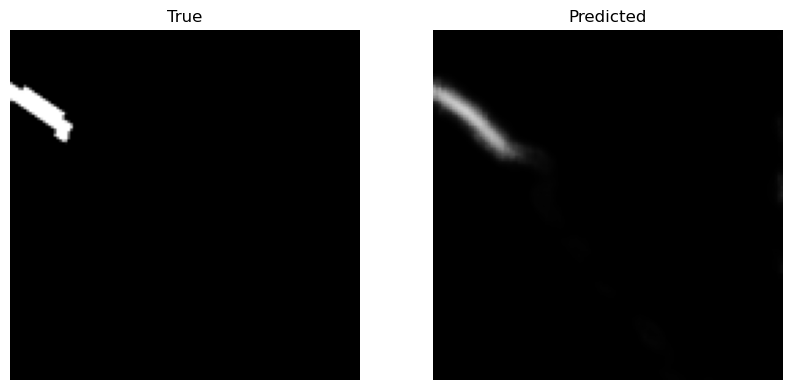

1/1 [==============================] - 0s 25ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 834ms/step - loss: 0.0497 - accuracy: 0.9751 - jaccard: 0.5529 - dice: 0.7116 - val_loss: 0.0673 - val_accuracy: 0.9697 - val_jaccard: 0.5015 - val_dice: 0.6665
Epoch 101/300
48/48 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9756 - jaccard: 0.5632 - dice: 0.7201
Epoch 101: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0485 - accuracy: 0.9756 - jaccard: 0.5632 - dice: 0.7201 - val_loss: 0.0748 - val_accuracy: 0.9668 - val_jaccard: 0.5121 - val_dice: 0.6747
Epoch 102/300
48/48 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9734 - jaccard: 0.5413 - dice: 0.7018
Epoch 102: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 287ms/step - loss: 0.0519 - accuracy: 0.9734 - jaccard: 0.5413 - dice: 0.7018 - val_loss: 0.0776 - val_accuracy: 0.9690

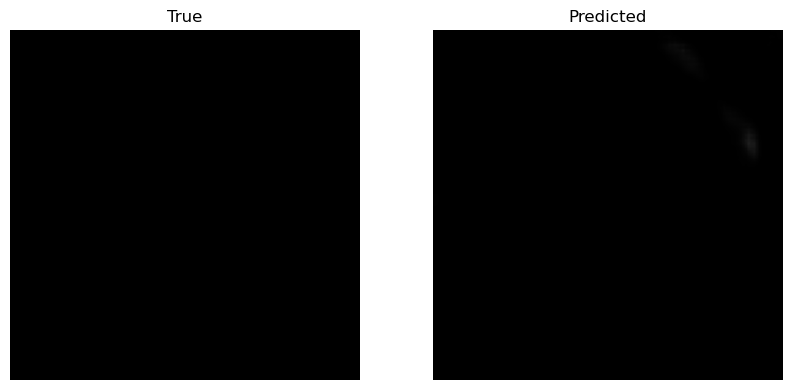

1/1 [==============================] - 0s 24ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 822ms/step - loss: 0.0504 - accuracy: 0.9745 - jaccard: 0.5516 - dice: 0.7103 - val_loss: 0.0737 - val_accuracy: 0.9674 - val_jaccard: 0.4805 - val_dice: 0.6450
Epoch 110/300
48/48 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9750 - jaccard: 0.5581 - dice: 0.7158
Epoch 110: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0487 - accuracy: 0.9750 - jaccard: 0.5581 - dice: 0.7158 - val_loss: 0.0709 - val_accuracy: 0.9688 - val_jaccard: 0.5195 - val_dice: 0.6819
Epoch 111/300
48/48 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9747 - jaccard: 0.5565 - dice: 0.7144
Epoch 111: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 280ms/step - loss: 0.0494 - accuracy: 0.9747 - jaccard: 0.5565 - dice: 0.7144 - val_loss: 0.0681 - val_accuracy: 0.9680

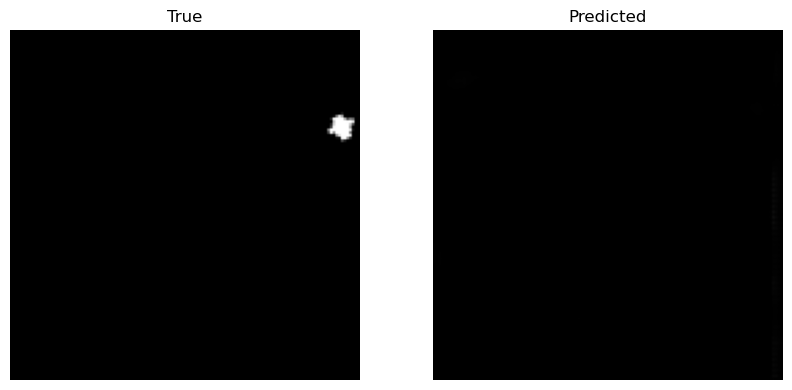

1/1 [==============================] - 0s 24ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 838ms/step - loss: 0.0455 - accuracy: 0.9775 - jaccard: 0.5826 - dice: 0.7357 - val_loss: 0.0791 - val_accuracy: 0.9678 - val_jaccard: 0.4975 - val_dice: 0.6627
Epoch 119/300
48/48 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9749 - jaccard: 0.5654 - dice: 0.7221
Epoch 119: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0484 - accuracy: 0.9749 - jaccard: 0.5654 - dice: 0.7221 - val_loss: 0.0807 - val_accuracy: 0.9672 - val_jaccard: 0.4981 - val_dice: 0.6625
Epoch 120/300
48/48 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9762 - jaccard: 0.5755 - dice: 0.7299
Epoch 120: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0462 - accuracy: 0.9762 - jaccard: 0.5755 - dice: 0.7299 - val_loss: 0.0728 - val_accuracy: 0.9697

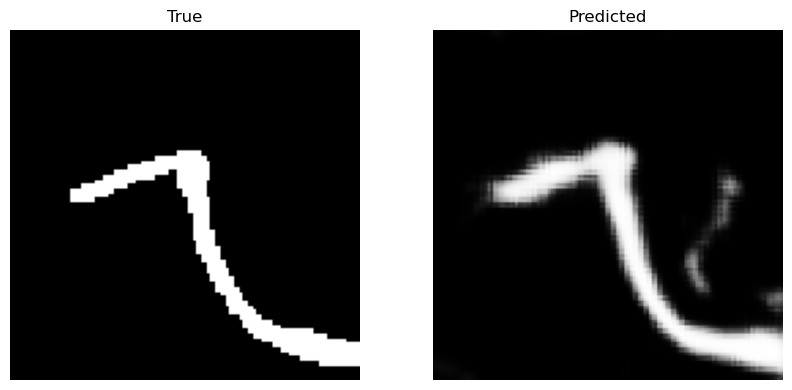

1/1 [==============================] - 0s 27ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 832ms/step - loss: 0.0450 - accuracy: 0.9770 - jaccard: 0.5857 - dice: 0.7382 - val_loss: 0.0746 - val_accuracy: 0.9634 - val_jaccard: 0.5276 - val_dice: 0.6887
Epoch 128/300
48/48 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9760 - jaccard: 0.5787 - dice: 0.7325
Epoch 128: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 292ms/step - loss: 0.0461 - accuracy: 0.9760 - jaccard: 0.5787 - dice: 0.7325 - val_loss: 0.0722 - val_accuracy: 0.9685 - val_jaccard: 0.5268 - val_dice: 0.6888
Epoch 129/300
48/48 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9752 - jaccard: 0.5741 - dice: 0.7286
Epoch 129: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0468 - accuracy: 0.9752 - jaccard: 0.5741 - dice: 0.7286 - val_loss: 0.0745 - val_accuracy: 0.9687

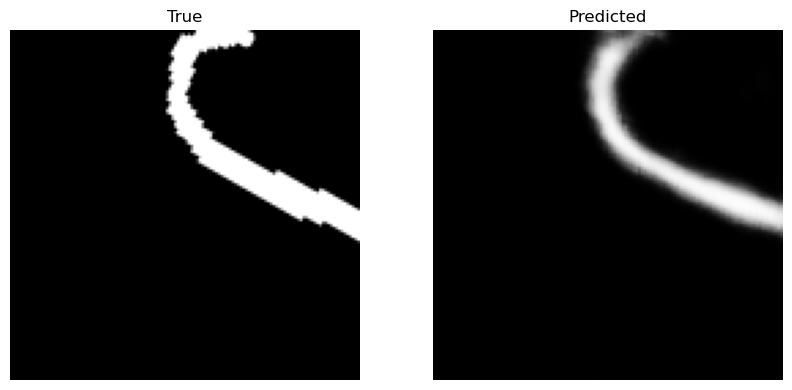

1/1 [==============================] - 0s 25ms/step
 
auc: 0.99
 
48/48 [==============================] - 46s 868ms/step - loss: 0.0449 - accuracy: 0.9765 - jaccard: 0.5871 - dice: 0.7394 - val_loss: 0.0815 - val_accuracy: 0.9656 - val_jaccard: 0.4969 - val_dice: 0.6619
Epoch 137/300
48/48 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9778 - jaccard: 0.6017 - dice: 0.7509
Epoch 137: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 281ms/step - loss: 0.0428 - accuracy: 0.9778 - jaccard: 0.6017 - dice: 0.7509 - val_loss: 0.0868 - val_accuracy: 0.9692 - val_jaccard: 0.5117 - val_dice: 0.6747
Epoch 138/300
48/48 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9772 - jaccard: 0.5952 - dice: 0.7458
Epoch 138: val_loss did not improve from 0.06568
48/48 [==============================] - 18s 279ms/step - loss: 0.0440 - accuracy: 0.9772 - jaccard: 0.5952 - dice: 0.7458 - val_loss: 0.0745 - val_accuracy: 0.9699

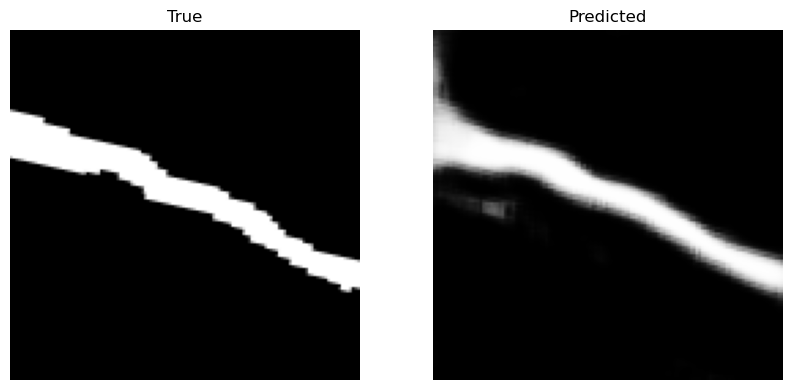

1/1 [==============================] - 0s 24ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 827ms/step - loss: 0.0427 - accuracy: 0.9780 - jaccard: 0.6069 - dice: 0.7547 - val_loss: 0.0837 - val_accuracy: 0.9673 - val_jaccard: 0.5253 - val_dice: 0.6872
Epoch 146/300
48/48 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9779 - jaccard: 0.6061 - dice: 0.7543
Epoch 146: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0424 - accuracy: 0.9779 - jaccard: 0.6061 - dice: 0.7543 - val_loss: 0.0768 - val_accuracy: 0.9670 - val_jaccard: 0.5081 - val_dice: 0.6726
Epoch 147/300
48/48 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9753 - jaccard: 0.5822 - dice: 0.7352
Epoch 147: val_loss did not improve from 0.06568
48/48 [==============================] - 20s 290ms/step - loss: 0.0459 - accuracy: 0.9753 - jaccard: 0.5822 - dice: 0.7352 - val_loss: 0.0770 - val_accuracy: 0.9686

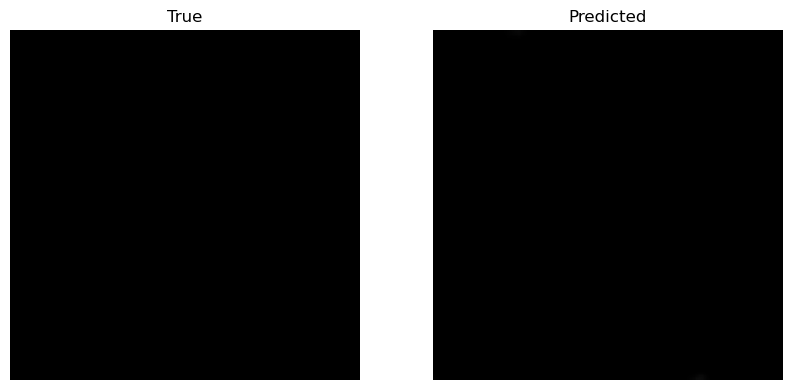

1/1 [==============================] - 0s 25ms/step
 
auc: 0.99
 
48/48 [==============================] - 45s 839ms/step - loss: 0.0396 - accuracy: 0.9792 - jaccard: 0.6276 - dice: 0.7709 - val_loss: 0.0801 - val_accuracy: 0.9657 - val_jaccard: 0.4977 - val_dice: 0.6626
Epoch 155/300
48/48 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9776 - jaccard: 0.6029 - dice: 0.7518
Epoch 155: val_loss did not improve from 0.06568
48/48 [==============================] - 24s 397ms/step - loss: 0.0430 - accuracy: 0.9776 - jaccard: 0.6029 - dice: 0.7518 - val_loss: 0.0785 - val_accuracy: 0.9694 - val_jaccard: 0.5317 - val_dice: 0.6930
Epoch 156/300
48/48 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9781 - jaccard: 0.6107 - dice: 0.7575
Epoch 156: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0421 - accuracy: 0.9781 - jaccard: 0.6107 - dice: 0.7575 - val_loss: 0.1042 - val_accuracy: 0.9657

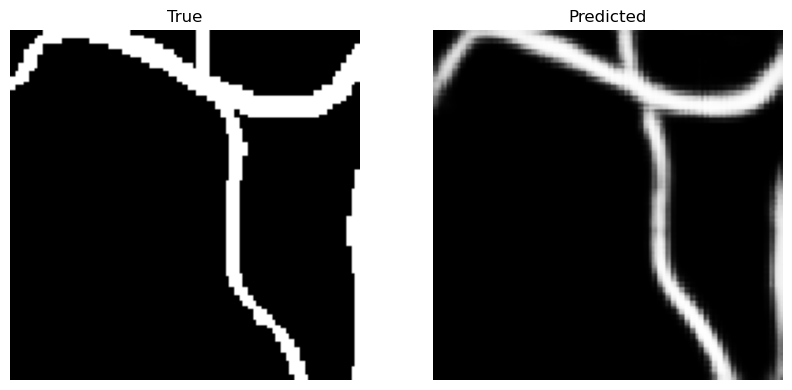

1/1 [==============================] - 0s 26ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 831ms/step - loss: 0.0408 - accuracy: 0.9781 - jaccard: 0.6188 - dice: 0.7640 - val_loss: 0.0821 - val_accuracy: 0.9677 - val_jaccard: 0.5187 - val_dice: 0.6811
Epoch 164/300
48/48 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9776 - jaccard: 0.6151 - dice: 0.7610
Epoch 164: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0412 - accuracy: 0.9776 - jaccard: 0.6151 - dice: 0.7610 - val_loss: 0.0848 - val_accuracy: 0.9678 - val_jaccard: 0.5067 - val_dice: 0.6702
Epoch 165/300
48/48 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9798 - jaccard: 0.6290 - dice: 0.7716
Epoch 165: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0390 - accuracy: 0.9798 - jaccard: 0.6290 - dice: 0.7716 - val_loss: 0.0865 - val_accuracy: 0.9680

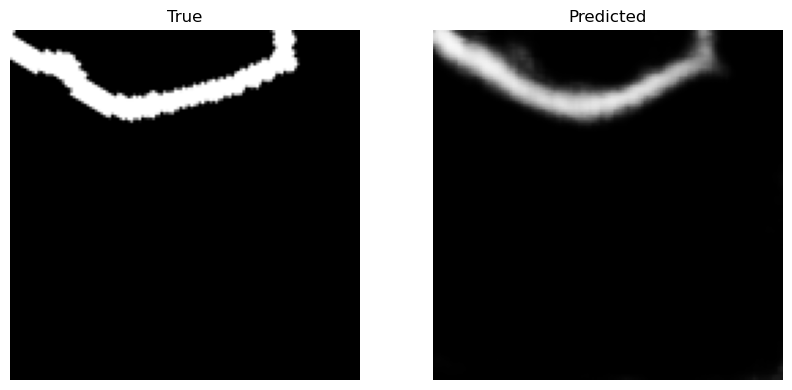

1/1 [==============================] - 0s 25ms/step
 
auc: 0.99
 
48/48 [==============================] - 44s 834ms/step - loss: 0.0386 - accuracy: 0.9799 - jaccard: 0.6379 - dice: 0.7786 - val_loss: 0.0958 - val_accuracy: 0.9675 - val_jaccard: 0.5101 - val_dice: 0.6737
Epoch 173/300
48/48 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9805 - jaccard: 0.6434 - dice: 0.7826
Epoch 173: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 284ms/step - loss: 0.0378 - accuracy: 0.9805 - jaccard: 0.6434 - dice: 0.7826 - val_loss: 0.0786 - val_accuracy: 0.9663 - val_jaccard: 0.5092 - val_dice: 0.6730
Epoch 174/300
48/48 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9807 - jaccard: 0.6477 - dice: 0.7857
Epoch 174: val_loss did not improve from 0.06568
48/48 [==============================] - 20s 300ms/step - loss: 0.0368 - accuracy: 0.9807 - jaccard: 0.6477 - dice: 0.7857 - val_loss: 0.0904 - val_accuracy: 0.9668

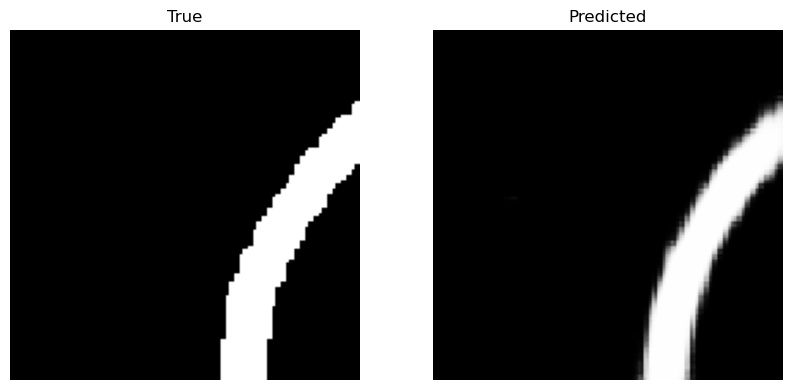

1/1 [==============================] - 0s 29ms/step
 
auc: 1.00
 
48/48 [==============================] - 45s 842ms/step - loss: 0.0363 - accuracy: 0.9806 - jaccard: 0.6514 - dice: 0.7882 - val_loss: 0.0872 - val_accuracy: 0.9683 - val_jaccard: 0.5376 - val_dice: 0.6975
Epoch 182/300
48/48 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9793 - jaccard: 0.6384 - dice: 0.7789
Epoch 182: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 287ms/step - loss: 0.0388 - accuracy: 0.9793 - jaccard: 0.6384 - dice: 0.7789 - val_loss: 0.0875 - val_accuracy: 0.9670 - val_jaccard: 0.5104 - val_dice: 0.6740
Epoch 183/300
48/48 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9789 - jaccard: 0.6376 - dice: 0.7784
Epoch 183: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 279ms/step - loss: 0.0384 - accuracy: 0.9789 - jaccard: 0.6376 - dice: 0.7784 - val_loss: 0.0797 - val_accuracy: 0.9653

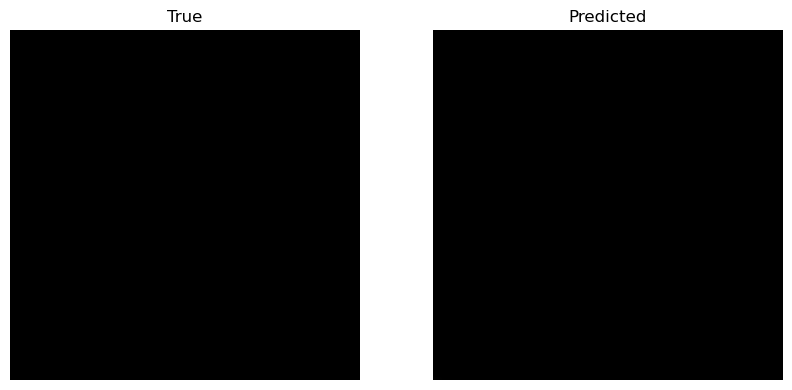

1/1 [==============================] - 0s 27ms/step
 
auc: 0.99
 
48/48 [==============================] - 45s 832ms/step - loss: 0.0406 - accuracy: 0.9774 - jaccard: 0.6217 - dice: 0.7663 - val_loss: 0.0884 - val_accuracy: 0.9685 - val_jaccard: 0.5288 - val_dice: 0.6901
Epoch 191/300
48/48 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9807 - jaccard: 0.6563 - dice: 0.7920
Epoch 191: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0358 - accuracy: 0.9807 - jaccard: 0.6563 - dice: 0.7920 - val_loss: 0.0959 - val_accuracy: 0.9681 - val_jaccard: 0.5199 - val_dice: 0.6816
Epoch 192/300
48/48 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9810 - jaccard: 0.6581 - dice: 0.7932
Epoch 192: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 290ms/step - loss: 0.0353 - accuracy: 0.9810 - jaccard: 0.6581 - dice: 0.7932 - val_loss: 0.0868 - val_accuracy: 0.9671

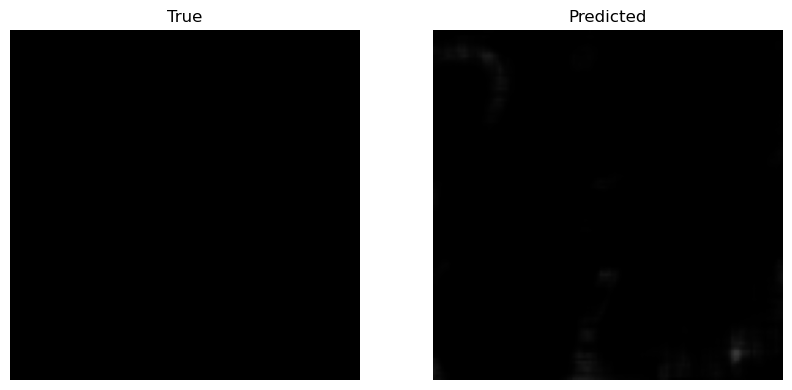

1/1 [==============================] - 0s 24ms/step
 
auc: 1.00
 
48/48 [==============================] - 44s 830ms/step - loss: 0.0356 - accuracy: 0.9808 - jaccard: 0.6570 - dice: 0.7924 - val_loss: 0.0871 - val_accuracy: 0.9681 - val_jaccard: 0.5366 - val_dice: 0.6969
Epoch 200/300
48/48 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9799 - jaccard: 0.6523 - dice: 0.7889
Epoch 200: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 282ms/step - loss: 0.0365 - accuracy: 0.9799 - jaccard: 0.6523 - dice: 0.7889 - val_loss: 0.0856 - val_accuracy: 0.9663 - val_jaccard: 0.5217 - val_dice: 0.6839
Epoch 201/300
48/48 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9802 - jaccard: 0.6572 - dice: 0.7926
Epoch 201: val_loss did not improve from 0.06568
48/48 [==============================] - 20s 290ms/step - loss: 0.0359 - accuracy: 0.9802 - jaccard: 0.6572 - dice: 0.7926 - val_loss: 0.0820 - val_accuracy: 0.9672

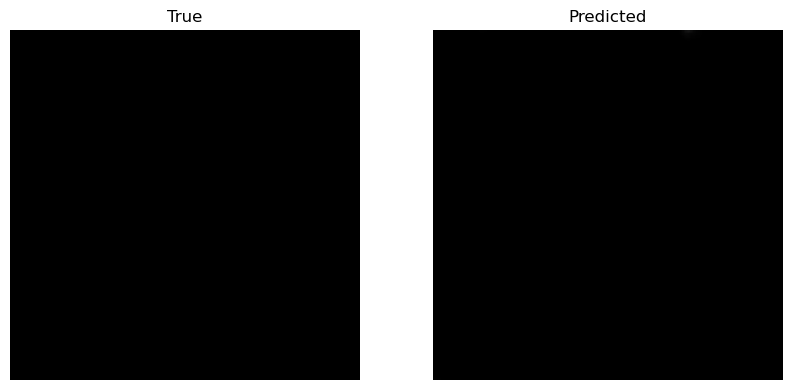

1/1 [==============================] - 0s 27ms/step
 
auc: 1.00
 
48/48 [==============================] - 46s 857ms/step - loss: 0.0370 - accuracy: 0.9794 - jaccard: 0.6499 - dice: 0.7874 - val_loss: 0.0826 - val_accuracy: 0.9681 - val_jaccard: 0.5409 - val_dice: 0.7005
Epoch 209/300
48/48 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9815 - jaccard: 0.6704 - dice: 0.8024
Epoch 209: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0341 - accuracy: 0.9815 - jaccard: 0.6704 - dice: 0.8024 - val_loss: 0.0939 - val_accuracy: 0.9662 - val_jaccard: 0.5337 - val_dice: 0.6940
Epoch 210/300
48/48 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9816 - jaccard: 0.6750 - dice: 0.8056
Epoch 210: val_loss did not improve from 0.06568
48/48 [==============================] - 18s 281ms/step - loss: 0.0337 - accuracy: 0.9816 - jaccard: 0.6750 - dice: 0.8056 - val_loss: 0.0834 - val_accuracy: 0.9676

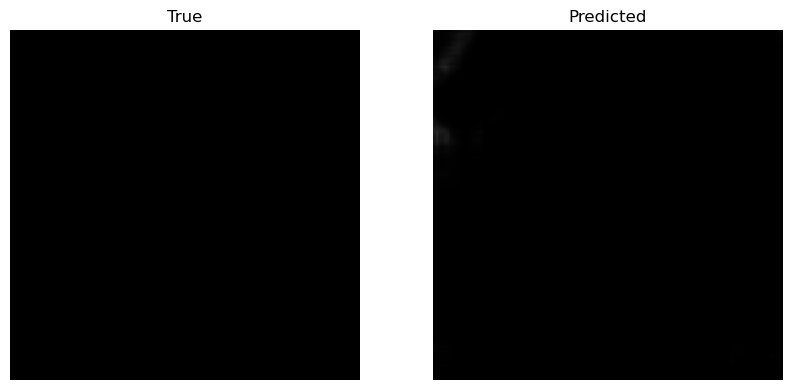

1/1 [==============================] - 0s 25ms/step
 
auc: 1.00
 
48/48 [==============================] - 45s 827ms/step - loss: 0.0332 - accuracy: 0.9819 - jaccard: 0.6782 - dice: 0.8079 - val_loss: 0.0904 - val_accuracy: 0.9658 - val_jaccard: 0.5294 - val_dice: 0.6910
Epoch 218/300
48/48 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9825 - jaccard: 0.6855 - dice: 0.8130
Epoch 218: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 296ms/step - loss: 0.0322 - accuracy: 0.9825 - jaccard: 0.6855 - dice: 0.8130 - val_loss: 0.1027 - val_accuracy: 0.9680 - val_jaccard: 0.5441 - val_dice: 0.7039
Epoch 219/300
48/48 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9817 - jaccard: 0.6804 - dice: 0.8093
Epoch 219: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 287ms/step - loss: 0.0329 - accuracy: 0.9817 - jaccard: 0.6804 - dice: 0.8093 - val_loss: 0.1024 - val_accuracy: 0.9667

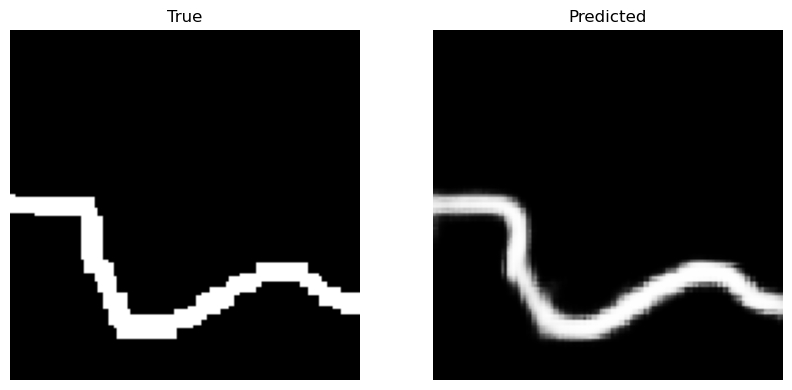

1/1 [==============================] - 0s 42ms/step
 
auc: 1.00
 
48/48 [==============================] - 45s 853ms/step - loss: 0.0344 - accuracy: 0.9805 - jaccard: 0.6657 - dice: 0.7986 - val_loss: 0.0804 - val_accuracy: 0.9677 - val_jaccard: 0.5355 - val_dice: 0.6964
Epoch 227/300
48/48 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9807 - jaccard: 0.6692 - dice: 0.8014
Epoch 227: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 287ms/step - loss: 0.0345 - accuracy: 0.9807 - jaccard: 0.6692 - dice: 0.8014 - val_loss: 0.0952 - val_accuracy: 0.9661 - val_jaccard: 0.5228 - val_dice: 0.6856
Epoch 228/300
48/48 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9816 - jaccard: 0.6728 - dice: 0.8037
Epoch 228: val_loss did not improve from 0.06568
48/48 [==============================] - 18s 280ms/step - loss: 0.0332 - accuracy: 0.9816 - jaccard: 0.6728 - dice: 0.8037 - val_loss: 0.0925 - val_accuracy: 0.9677

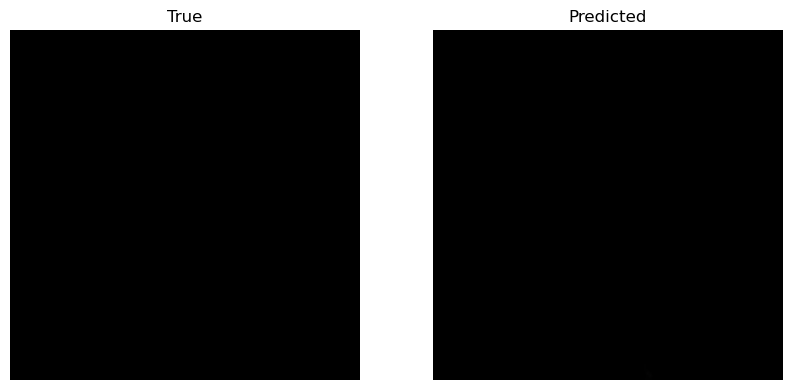

1/1 [==============================] - 0s 25ms/step
 
auc: 1.00
 
48/48 [==============================] - 45s 856ms/step - loss: 0.0305 - accuracy: 0.9834 - jaccard: 0.6986 - dice: 0.8220 - val_loss: 0.0904 - val_accuracy: 0.9666 - val_jaccard: 0.5360 - val_dice: 0.6968
Epoch 236/300
48/48 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9831 - jaccard: 0.6979 - dice: 0.8216
Epoch 236: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 293ms/step - loss: 0.0308 - accuracy: 0.9831 - jaccard: 0.6979 - dice: 0.8216 - val_loss: 0.1036 - val_accuracy: 0.9665 - val_jaccard: 0.5207 - val_dice: 0.6822
Epoch 237/300
48/48 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9824 - jaccard: 0.6916 - dice: 0.8172
Epoch 237: val_loss did not improve from 0.06568
48/48 [==============================] - 18s 284ms/step - loss: 0.0317 - accuracy: 0.9824 - jaccard: 0.6916 - dice: 0.8172 - val_loss: 0.0983 - val_accuracy: 0.9679

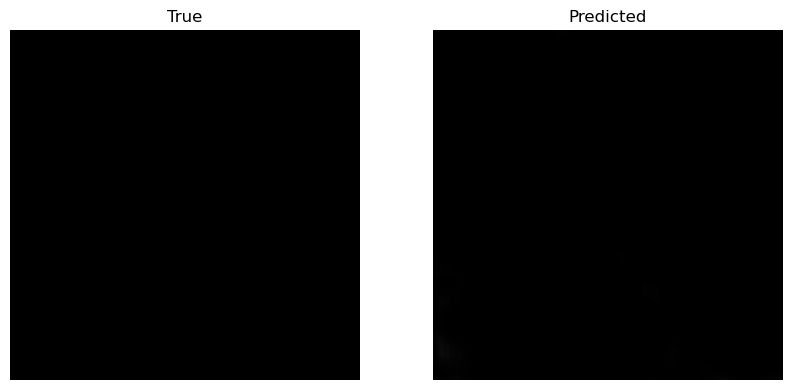

1/1 [==============================] - 0s 25ms/step
 
auc: 1.00
 
48/48 [==============================] - 44s 827ms/step - loss: 0.0306 - accuracy: 0.9828 - jaccard: 0.7015 - dice: 0.8242 - val_loss: 0.1011 - val_accuracy: 0.9684 - val_jaccard: 0.5367 - val_dice: 0.6965
Epoch 245/300
48/48 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9832 - jaccard: 0.7003 - dice: 0.8233
Epoch 245: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 285ms/step - loss: 0.0305 - accuracy: 0.9832 - jaccard: 0.7003 - dice: 0.8233 - val_loss: 0.0910 - val_accuracy: 0.9647 - val_jaccard: 0.5258 - val_dice: 0.6880
Epoch 246/300
48/48 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9841 - jaccard: 0.7095 - dice: 0.8296
Epoch 246: val_loss did not improve from 0.06568
48/48 [==============================] - 24s 398ms/step - loss: 0.0291 - accuracy: 0.9841 - jaccard: 0.7095 - dice: 0.8296 - val_loss: 0.0959 - val_accuracy: 0.9660

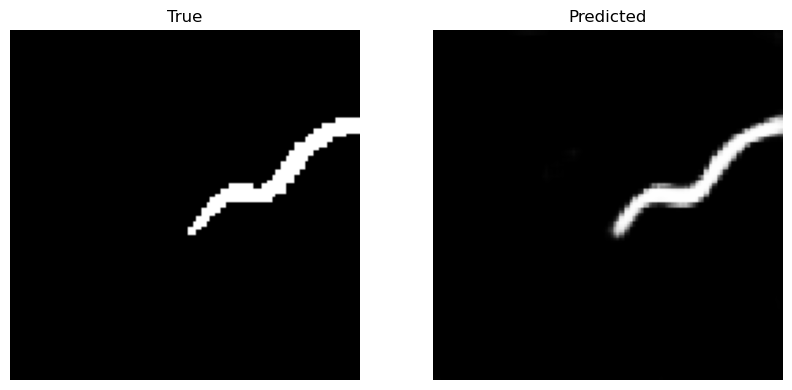

1/1 [==============================] - 0s 28ms/step
 
auc: 1.00
 
48/48 [==============================] - 44s 826ms/step - loss: 0.0307 - accuracy: 0.9831 - jaccard: 0.6987 - dice: 0.8221 - val_loss: 0.0893 - val_accuracy: 0.9661 - val_jaccard: 0.5332 - val_dice: 0.6935
Epoch 254/300
48/48 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9854 - jaccard: 0.7290 - dice: 0.8427
Epoch 254: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 297ms/step - loss: 0.0267 - accuracy: 0.9854 - jaccard: 0.7290 - dice: 0.8427 - val_loss: 0.0956 - val_accuracy: 0.9685 - val_jaccard: 0.5557 - val_dice: 0.7130
Epoch 255/300
48/48 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9834 - jaccard: 0.7083 - dice: 0.8286
Epoch 255: val_loss did not improve from 0.06568
48/48 [==============================] - 18s 278ms/step - loss: 0.0296 - accuracy: 0.9834 - jaccard: 0.7083 - dice: 0.8286 - val_loss: 0.0965 - val_accuracy: 0.9670

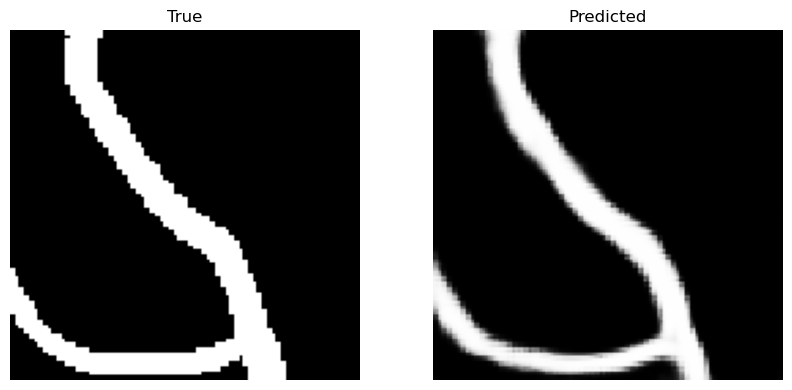

1/1 [==============================] - 0s 29ms/step
 
auc: 1.00
 
48/48 [==============================] - 45s 845ms/step - loss: 0.0317 - accuracy: 0.9818 - jaccard: 0.6904 - dice: 0.8164 - val_loss: 0.0917 - val_accuracy: 0.9663 - val_jaccard: 0.5228 - val_dice: 0.6847
Epoch 263/300
48/48 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9830 - jaccard: 0.6978 - dice: 0.8214
Epoch 263: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 296ms/step - loss: 0.0304 - accuracy: 0.9830 - jaccard: 0.6978 - dice: 0.8214 - val_loss: 0.0872 - val_accuracy: 0.9659 - val_jaccard: 0.5435 - val_dice: 0.7029
Epoch 264/300
48/48 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9819 - jaccard: 0.6918 - dice: 0.8172
Epoch 264: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 296ms/step - loss: 0.0318 - accuracy: 0.9819 - jaccard: 0.6918 - dice: 0.8172 - val_loss: 0.0956 - val_accuracy: 0.9665

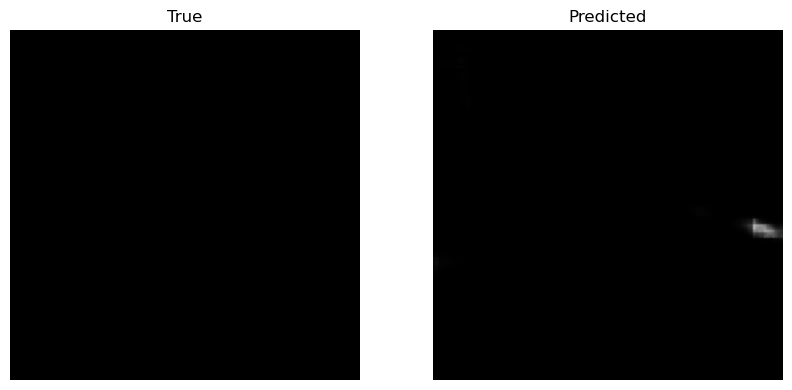

1/1 [==============================] - 0s 26ms/step
 
auc: 1.00
 
48/48 [==============================] - 46s 859ms/step - loss: 0.0293 - accuracy: 0.9832 - jaccard: 0.7098 - dice: 0.8299 - val_loss: 0.1039 - val_accuracy: 0.9669 - val_jaccard: 0.5518 - val_dice: 0.7097
Epoch 272/300
48/48 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9845 - jaccard: 0.7263 - dice: 0.8410
Epoch 272: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 291ms/step - loss: 0.0274 - accuracy: 0.9845 - jaccard: 0.7263 - dice: 0.8410 - val_loss: 0.1086 - val_accuracy: 0.9674 - val_jaccard: 0.5397 - val_dice: 0.6997
Epoch 273/300
48/48 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9811 - jaccard: 0.6853 - dice: 0.8128
Epoch 273: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 292ms/step - loss: 0.0327 - accuracy: 0.9811 - jaccard: 0.6853 - dice: 0.8128 - val_loss: 0.1131 - val_accuracy: 0.9668

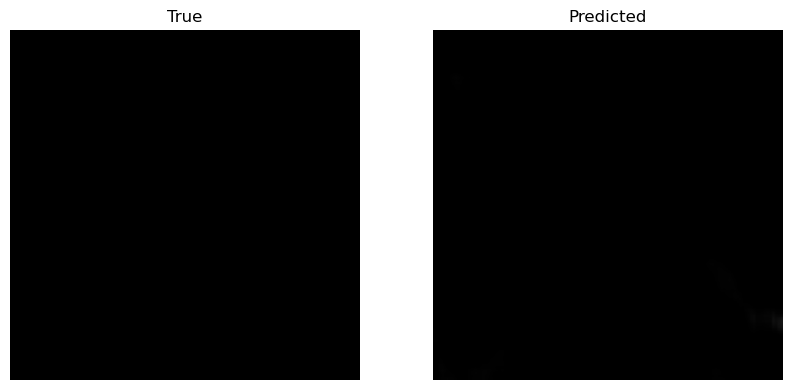

1/1 [==============================] - 0s 25ms/step
 
auc: 1.00
 
48/48 [==============================] - 46s 858ms/step - loss: 0.0302 - accuracy: 0.9826 - jaccard: 0.7057 - dice: 0.8271 - val_loss: 0.1118 - val_accuracy: 0.9689 - val_jaccard: 0.5350 - val_dice: 0.6950
Epoch 281/300
48/48 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9825 - jaccard: 0.6921 - dice: 0.8175
Epoch 281: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 294ms/step - loss: 0.0313 - accuracy: 0.9825 - jaccard: 0.6921 - dice: 0.8175 - val_loss: 0.0933 - val_accuracy: 0.9676 - val_jaccard: 0.5423 - val_dice: 0.7011
Epoch 282/300
48/48 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9826 - jaccard: 0.7033 - dice: 0.8254
Epoch 282: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 286ms/step - loss: 0.0304 - accuracy: 0.9826 - jaccard: 0.7033 - dice: 0.8254 - val_loss: 0.1039 - val_accuracy: 0.9677

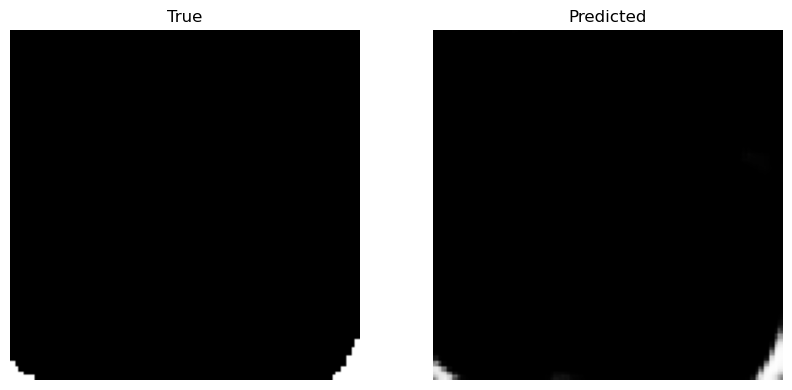

1/1 [==============================] - 0s 38ms/step
 
auc: 1.00
 
48/48 [==============================] - 46s 858ms/step - loss: 0.0318 - accuracy: 0.9817 - jaccard: 0.6911 - dice: 0.8168 - val_loss: 0.0893 - val_accuracy: 0.9685 - val_jaccard: 0.5488 - val_dice: 0.7076
Epoch 290/300
48/48 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9837 - jaccard: 0.7170 - dice: 0.8349
Epoch 290: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 289ms/step - loss: 0.0286 - accuracy: 0.9837 - jaccard: 0.7170 - dice: 0.8349 - val_loss: 0.0959 - val_accuracy: 0.9684 - val_jaccard: 0.5492 - val_dice: 0.7077
Epoch 291/300
48/48 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9839 - jaccard: 0.7199 - dice: 0.8367
Epoch 291: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 294ms/step - loss: 0.0283 - accuracy: 0.9839 - jaccard: 0.7199 - dice: 0.8367 - val_loss: 0.0890 - val_accuracy: 0.9682

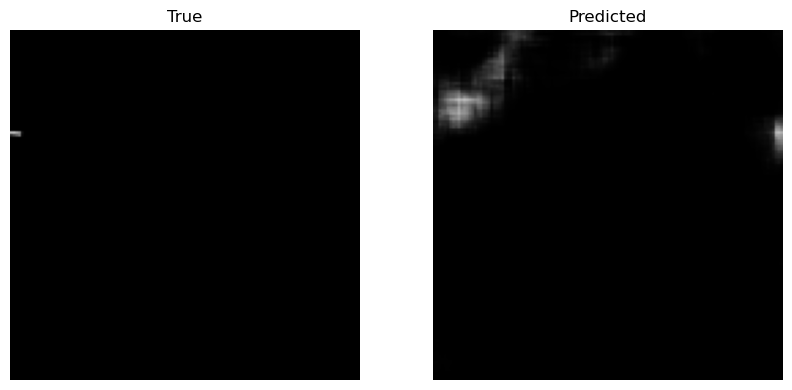

1/1 [==============================] - 0s 25ms/step
 
auc: 1.00
 
48/48 [==============================] - 45s 839ms/step - loss: 0.0291 - accuracy: 0.9832 - jaccard: 0.7122 - dice: 0.8314 - val_loss: 0.0984 - val_accuracy: 0.9669 - val_jaccard: 0.5380 - val_dice: 0.6977
Epoch 299/300
48/48 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9840 - jaccard: 0.7158 - dice: 0.8340
Epoch 299: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0287 - accuracy: 0.9840 - jaccard: 0.7158 - dice: 0.8340 - val_loss: 0.0964 - val_accuracy: 0.9649 - val_jaccard: 0.5324 - val_dice: 0.6927
Epoch 300/300
48/48 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9854 - jaccard: 0.7399 - dice: 0.8501
Epoch 300: val_loss did not improve from 0.06568
48/48 [==============================] - 19s 288ms/step - loss: 0.0262 - accuracy: 0.9854 - jaccard: 0.7399 - dice: 0.8501 - val_loss: 0.1047 - val_accuracy: 0.9658

In [129]:
history1 = model1.fit(train_dataset, epochs=300, verbose=1, 
                    callbacks=[checkpointer, CustomCallback(model1, train_dataset)],
                    validation_data=val_dataset)


In [130]:
time_start2 = datetime.datetime.now()
print("Training time = ", time_start2 - time_start1)

Training time =  2:05:29.281460


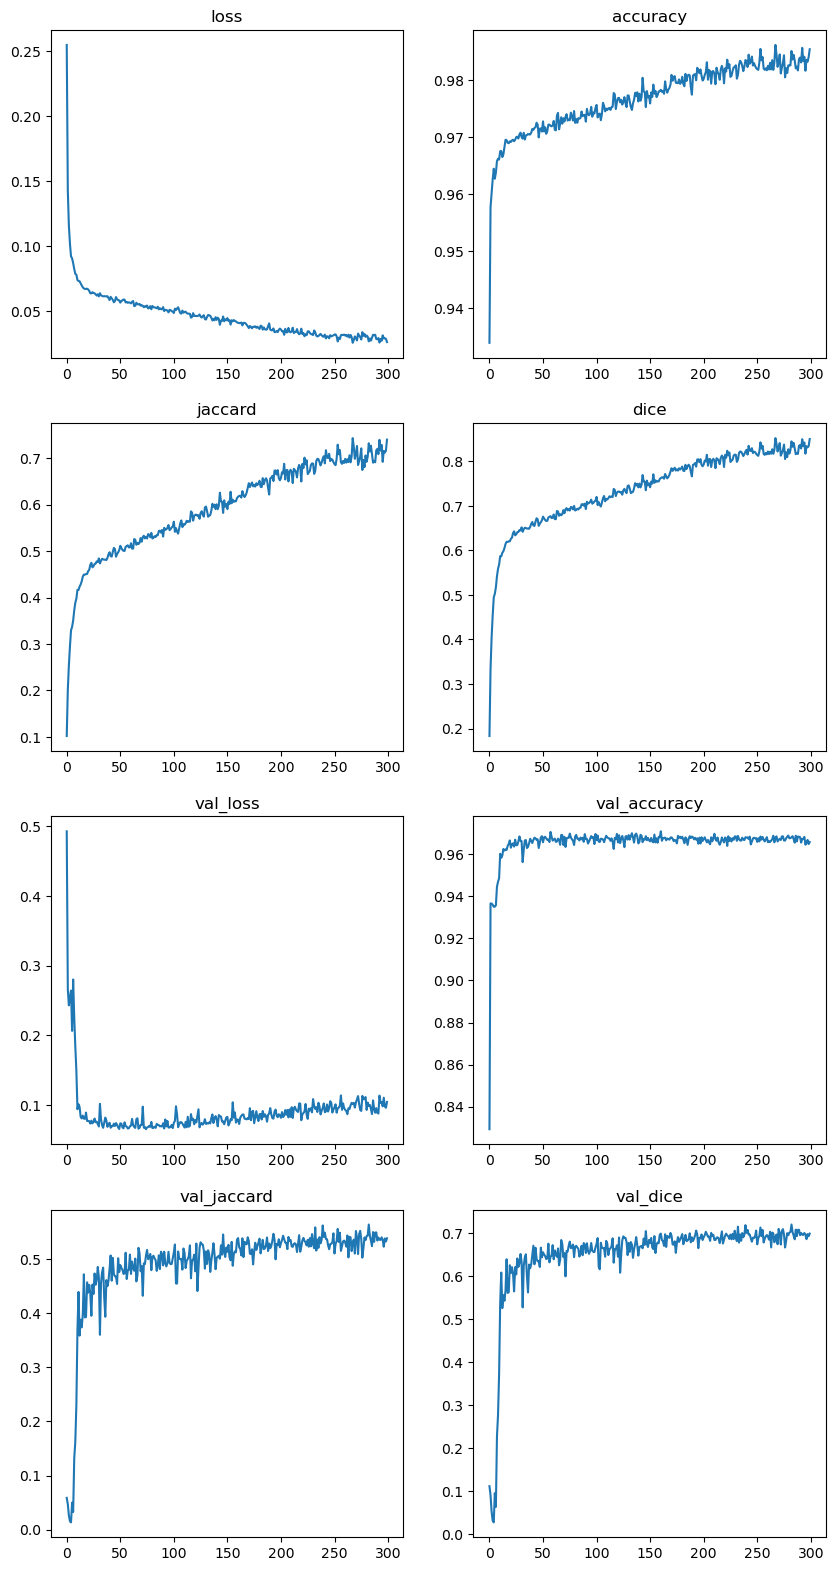

In [131]:
plt.figure(figsize=(10, 40))

for idx, key in enumerate(history1.history.keys()):
    
    ax = plt.subplot(8, 2, 1 + idx)
    plt.title(key)
    plt.plot(history1.history[key])

plt.show()

*******************************************************

# **Tester sur all-dataset-deep dataset par patient et par coro sur black**

In [132]:
# The test batch size is equal to the number of pieces cut from the original
# image, this was done so that we can reconstruct the image later.

test_batch = (resize_wh // crop_wh)**2

In [133]:
#path_imgs = "../input/partie-01/partie_01/"  #with blacks
path_imgs = "../input/all-dataset-deep/all_dataset_deep/"
imgs_test = []
label_imgs_test = []

In [134]:
path_imgs.index('_')

29

In [135]:
height = 512
width = 512
channels = 1

In [136]:
import os
import shutil
from os.path import join

In [137]:
path_imgs

'../input/all-dataset-deep/all_dataset_deep/'

In [138]:
liste_patients=os.listdir(path_imgs)
nb_p=len(liste_patients)
print( nb_p )

for p in liste_patients:
    path_patient=join(path_imgs,p)  
        
    liste_coros=os.listdir(path_patient)
    for c in liste_coros:
        path_coro=join(path_patient,c)    
        liste_rep=os.listdir(path_coro)
        
        path_frames=join(path_coro,"frames")
        liste_frames=os.listdir(path_frames)
        for f in liste_frames:
            path_f=join(path_frames,f)
            imgs_test.append(path_f)

        path_blacks=join(path_coro,"blacks")
        liste_blacks=os.listdir(path_blacks)
        for b in liste_blacks:
            path_b=join(path_blacks,b)
            label_imgs_test.append(path_b)


print('nb frames=',len(imgs_test))
print('nb blacks=',len(label_imgs_test))

19
nb frames= 3261
nb blacks= 3261


In [139]:
print(imgs_test[0])
print(label_imgs_test[0])

../input/all-dataset-deep/all_dataset_deep/BEN_MASSMIA_CHEDLY_CORO_26107/CORO_2020_0004/frames/frame_00012.jpg
../input/all-dataset-deep/all_dataset_deep/BEN_MASSMIA_CHEDLY_CORO_26107/CORO_2020_0004/blacks/frame_00012.jpg


In [140]:
test_file_names = imgs_test    #os.listdir(imgs_test)
test_labels = label_imgs_test   #os.listdir(label_imgs_test)

test_file_names.sort(key=lambda f: int(re.sub('\D', '', f)))
test_labels.sort(key=lambda f: int(re.sub('\D', '', f)))

In [141]:
print(len(test_file_names))
print(len(test_labels))

3261
3261


In [142]:
test_labels1=test_labels
test_file_names1=test_file_names

In [143]:
#pour tester sur quelque lignes seulement
test_file_names=test_file_names1[:1000]
test_labels=test_labels1[:1000]

In [144]:
test_file_names[0]

'../input/all-dataset-deep/all_dataset_deep/HARRABI_ALI_CORO_23770/CORO_2020_0001/frames/frame_00000.jpg'

In [145]:
name=test_file_names[0]
L=name.split('/')
name=L[-1]
name

'frame_00000.jpg'

In [146]:
def load2(image_paths, label_paths):
    
    image_string = tf.io.read_file(image_paths)
    label_string = tf.io.read_file(label_paths)
    
    #Don't use tf.image.decode_image, or the output shape will be undefined
    ##image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.io.decode_jpeg(image_string, channels=1) ##### kénit channels=1
    # decode_jpeg : Decode a JPEG-encoded image to a uint8 tensor.
    label = tf.io.decode_jpeg(label_string,channels=1)  
    # The attr channels indicates the desired number of color channels for the decoded image.
  
    #=======
    #label = tf.image.rgb_to_grayscale(label)
    image = tf.cast(image, dtype=tf.float32)
    # transforme image en float32
    label = tf.cast(label, dtype=tf.float32)

    image.set_shape((height, width, 1))  #### 1
    label.set_shape((height, width, 1))

    print('Load2')
    print("!!! ",image.shape) #Check image shape
    print("!!! ",label.shape) #Check label shape

    return image, label

In [147]:
#Add a print statement to see the image size.
def parse_function_test2(image, label):
    
    image_shape = image.shape
    label_shape = label.shape

    #print(image.shape) #Check image shape
    #print(label.shape) #Check label shape

    image = tf.py_function(clahe_equalized, [image], tf.uint8)
    image.set_shape(image_shape)

    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.image.convert_image_dtype(label, tf.float32) / 255

    image, label = crop(image, label, crop_wh, image.shape[-1])

    print('~~~',image.shape) #Check image shape
    print('~~~',label.shape) #Check label shape

    return image, label

In [148]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_file_names, test_labels))

test_dataset = test_dataset.map(load2)
test_dataset = test_dataset.map(parse_function_test2)

test_dataset = test_dataset.flat_map(
    lambda image, label: tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(image), 
    tf.data.Dataset.from_tensor_slices(label))
    ))

test_dataset = test_dataset.batch(test_batch).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(test_dataset)

Load2
!!!  (512, 512, 1)
!!!  (512, 512, 1)
~~~ (16, 128, 128, 1)
~~~ (16, 128, 128, 1)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [149]:
score5=model1.evaluate(test_dataset)

print('Test loss:', score5[0])
print('Test accuracy:', score5[1])
print("%s: %.2f%%" % (model1.metrics_names[1], score5[1]*100))

1000/1000 [==============================] - 28s 28ms/step - loss: 0.0870 - accuracy: 0.9679 - jaccard: 0.0000e+00 - dice: 0.0000e+00
Test loss: 0.08695531636476517
Test accuracy: 0.9679361581802368
accuracy: 96.79%


In [150]:
def rebuild_image(image_cropped, label_cropped, image_pred_cropped):
    
    image = np.ones((resize_wh, resize_wh, 1))
    label = np.ones((resize_wh, resize_wh, 1))
    image_pred = np.ones((resize_wh, resize_wh, 1))

    cont = 0

    for idx in range(0, image.shape[1] // crop_wh):
        for idy in range(0, image.shape[0] // crop_wh):
          
          image[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_cropped[cont, ...]
          label[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = label_cropped[cont, ...]
          image_pred[idy * crop_wh: (idy + 1) * crop_wh, idx * crop_wh: (idx + 1) * crop_wh, :] = image_pred_cropped[cont, ...]
          cont += 1

    return image, label, image_pred

In [151]:
def color_labels(label, image_pred):

    color_label = np.zeros((resize_wh, width, 1))   ####3 

    i_t, j_t = np.where(label[..., 0] > 0.9)  ###0.1
    #print(i_t)

    # Color with white pixels where labels are equal to one.
    color_label[i_t, j_t, :] = 255
    
    i, j = np.where(image_pred[..., 0] > 0.4)   ###0.5
    
    label_set = set([(a, b) for a, b in zip(i_t, j_t)])
    pred_set = set([(a, b) for a, b in zip(i, j)])
    pred_tp = set(label_set).intersection(pred_set)
    
    
    #pred_tp : true positif
    # pred_fp : false positif
    
    pred_fp = pred_set - pred_tp
    
    #print('taille pred_set=',len(pred_set))
    #print('taille pred_tp=',len(pred_tp))
    #print('taille pred_fp=',len(pred_fp))
    
    k1, k2 = zip(*pred_fp)   
    color_label[k1, k2, 0:2] = 255

    k1, k2 = zip(*pred_fp)
    color_label[k1, k2, 1:2] = 255

    return color_label

In [152]:
def afficher_images(image,image_pred,label):
    cmap = plt.cm.gray
    fig, axes = plt.subplots(1,3,figsize=(20,5))
    
    axes[0].set_title('image')
    axes[0].imshow(image, cmap=cmap, aspect='auto')
    
    axes[1].set_title('image_pred')
    axes[1].imshow(image_pred, cmap=cmap, aspect='auto')
    
    axes[2].set_title('pred_label')
    axes[2].imshow(label, cmap=cmap, aspect='auto')
    
    plt.tight_layout()
    plt.show()


In [153]:
import datetime
time_start1 = datetime.datetime.now()
print("     Training Start at", time_start1)

     Training Start at 2023-03-11 22:55:14.817189


In [155]:
import os
from pathlib import Path
from os.path import join
i=0
print("begin")
path_to_save="segmented_all_dataset_deep_0_1000"

if os.path.exists(Path(path_to_save)) :
    shutil.rmtree(path_to_save)
os.mkdir(path_to_save)

for data in test_dataset:
  #  
  
  image_cropped = data[0].numpy()
  label_cropped = data[1].numpy()

  #print('===',image_cropped.shape)
  #print('===',label_cropped.shape)
  image_pred_cropped = model1.predict(image_cropped)
  #cv2.imwrite("image_pred_cropped.jpg", image_pred_cropped)
  #print('===',image_pred_cropped.shape)
  image, label, image_pred = rebuild_image(image_cropped,
                                           label_cropped,
                                           image_pred_cropped) 
  #afficher_images(image,image_pred,label)
  
  name=test_file_names[i]
  index = name.find('.jpg')
  name = name[:index] + '_gt' + name[index:]
  index=name.find('/')
  name=name[index+1:]
  index=name.find('/')
  name=name[index+1:]
  index=name.find('/')
  name=name[index+1:]
  index=name.find('/')
  name=name[index+1:]
  #print(name)

  name=name.replace('/', '-') 
    
  name_img=os.path.join(path_to_save,name) 

  print(i,' ',name_img)
    
  label = color_labels(label, image_pred) 

  #plt.figure(figsize=(20, 20))
  #ax = plt.subplot(1, 2, 1)
  image = cv2.cvtColor(image.astype('float32'), cv2.IMREAD_COLOR)
  
  #plt.imshow(image)
  #plt.axis('off')

  #ax = plt.subplot(1, 2, 2)
  pred_label = cv2.cvtColor(label.astype('uint8'), cv2.IMREAD_COLOR)
  
  #afficher_images(image,image_pred,pred_label)
    
  #plt.imshow(pred_label)
  #plt.axis('off')
  #plt.show()   
  
  #print(i , name_img , ' to save... ')

  r=cv2.imwrite(name_img,pred_label)    ####pred_label)
  if r :
      #print(i , name_img , ' saved ')
      pass
  else:
      print(i , name_img , ' not saved ')
  i+=1

begin
1/1 [==============================] - 0s 25ms/step
0   segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0001-frames-frame_00000_gt.jpg
1/1 [==============================] - 0s 25ms/step
1   segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0001-frames-frame_00001_gt.jpg
1/1 [==============================] - 0s 27ms/step
2   segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0001-frames-frame_00002_gt.jpg
1/1 [==============================] - 0s 28ms/step
3   segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0001-frames-frame_00003_gt.jpg
1/1 [==============================] - 0s 23ms/step
4   segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0001-frames-frame_00004_gt.jpg
1/1 [==============================] - 0s 25ms/step
5   segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0001-frames-frame_00005_gt.jpg
1/1 [==============================] - 0s 58ms/step
6   segmented_all_

In [156]:
time_start2 = datetime.datetime.now()
print("Training time = ", time_start2 - time_start1)

Training time =  0:03:56.270265


============================================================

In [157]:
import os
file='output.zip'
if os.path.exists(Path(file)) :
    os.remove(file)
!zip -r output.zip /kaggle/working#/segmented_all_dataset_deep_0_1000

  adding: kaggle/working/segmented_all_dataset_deep_0_1000/ (stored 0%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/BADRANI_FATMA_CORO_23801-CORO_2020_0006-frames-frame_00022_gt.jpg_ (deflated 16%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/NJEH_BECHIR_CORO24251-CORO_2020_0005-frames-frame_00014_gt.jpg (deflated 18%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/NJEH_BECHIR_CORO24251-CORO_2020_0001-frames-frame_00019_gt.jpg (deflated 19%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0005-frames-frame_00030_gt.jpg (deflated 19%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/BADRANI_FATMA_CORO_23801-CORO_2020_0001-frames-frame_00003_gt.jpg_ (deflated 39%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0002-frames-frame_00044_gt.jpg (deflated 53%)
  adding: kaggle/working/segmented_all_dataset_deep_0_1000/HARRABI_ALI_CORO_23770-CORO_2020_0003

In [158]:
#os.remove('output.zip')
#os.remove('my_Unet_DRIVE.h5')
"""import shutil
shutil.rmtree('segmented_partie_01')"""

"import shutil\nshutil.rmtree('segmented_partie_01')"

In [159]:
"""import cv2
path1= "../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/Original/train/1.png"
img1=cv2.imread(path1)
print(type(img1),' ',img1.shape)"""

'import cv2\npath1= "../input/dataset-deep-angiogram-png/dataset_deep_Angiogram_png/Original/train/1.png"\nimg1=cv2.imread(path1)\nprint(type(img1),\' \',img1.shape)'

In [160]:
"""path = "../input/partie-01/partie_01/GAMMOUDI_LAMINE_CORO_25376/CORO_2020_0001/blacks/frame_00000.jpg"
img=cv2.imread(path)
print(type(img),' ',img.shape)"""

'path = "../input/partie-01/partie_01/GAMMOUDI_LAMINE_CORO_25376/CORO_2020_0001/blacks/frame_00000.jpg"\nimg=cv2.imread(path)\nprint(type(img),\' \',img.shape)'

In [161]:
"""
path = "../input/coro3-misseoui/CORO3_misseoui/black_frames/frame_00000.jpg"
img=cv2.imread(path)
print(type(img),' ',img.shape)

#<class 'numpy.ndarray'>   (512, 512, 3)
"""

'\npath = "../input/coro3-misseoui/CORO3_misseoui/black_frames/frame_00000.jpg"\nimg=cv2.imread(path)\nprint(type(img),\' \',img.shape)\n\n#<class \'numpy.ndarray\'>   (512, 512, 3)\n'

In [162]:
"""path = "../input/partie-01/partie_01/GAMMOUDI_LAMINE_CORO_25376/CORO_2020_0001/frames/frame_00000.jpg"
img=cv2.imread(path)
print(type(img),' ',img.shape)"""

'path = "../input/partie-01/partie_01/GAMMOUDI_LAMINE_CORO_25376/CORO_2020_0001/frames/frame_00000.jpg"\nimg=cv2.imread(path)\nprint(type(img),\' \',img.shape)'

In [163]:
path="/kaggle/working/segmented_all_dataset_deep_0_1000"
L=os.listdir(path)
print(len(L))

1000
